In [3]:
import re
import gc
import os
import pickle
import random
from preprocess import preprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold,StratifiedKFold, train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D, GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional, LSTM

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_colwidth',-1)

In [4]:
df_ = pd.read_csv(r'DK.csv', encoding='utf-8')
# df.head(25)

In [5]:
df_['NegetiveFeedback'].value_counts()

0    2624635
1    308112 
Name: NegetiveFeedback, dtype: int64

In [6]:
df_['len'] = df_['Comment'].astype(str).apply(lambda x: len(x.split()))
df_.head()

,Unnamed: 0,BadComment,Comment,Date,GoodComment,ItemURL,NegetiveFeedback,Person,PositiveFeedback,SubCatName,SubName,Unnamed: 0.1,Unnamed: 0.1.1,len
0,0,۰,<p>من کاملا با این محصول آشنا بودم و از خریدش مطمین بودم</p>,\r\n در تاریخ ۲ مهر ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n سمانه خلج مهرآبادي\r\n,1,ساعت هوشمند,کالای دیجیتال,NaN,NaN,12
1,1,۲,<p>به درد خاصی نمیخوره صرفا یکی دو روز باهاش سرگرمین بعد به عنوان یه ساعت معمولی ازش استفاده میکنین</p>,\r\n در تاریخ ۱ مهر ۱۳۹۹\r\n,۴,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محجوبه زارعی\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,19
2,2,۰,<p>در یک کلام به نسبت هزینه ای که میکنید کالمل ترین ساعت بازار رو دریافت می‌کنید<br/>\r\r\nدسترسی کامل به نوتیفیکشن ها و توانایی به پاسخ دادن به پیام ها از طریق خود ساعت<br/>\r\r\nهمچنین برنامه کامل ورزشی تمام نیاز های شما رو برآورده میکنه</p>,\r\n در تاریخ ۳۱ شهریور ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محمد رضا میرشکار سیاهکل\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,44
3,3,۰,<p>ساعت بسیار عالی و کاربردی هست،میخواستم برای دوستم هم بگیرم ولی به دلیل تفاوت قیمت زیاد از دیجی کالا نمیخرم،</p>,\r\n در تاریخ ۲۹ شهریور ۱۳۹۹\r\n,۰,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n کاربر دیجی‌کالا\r\n,0,ساعت هوشمند,کالای دیجیتال,NaN,NaN,20
4,4,۰,<p>دقیقا مطابق آنچه انتظار می رفت بود .<br/>\r\r\nخوب و کاربردی و مطابق استایل روز .</p>,\r\n در تاریخ ۲۹ شهریور ۱۳۹۹\r\n,۱,/product/dkp-1878144/ساعت-هوشمند-سامسونگ-مدل-galaxy-watch-active2-44mm,0,\r\n محمد میرفخرایی\r\n,1,ساعت هوشمند,کالای دیجیتال,NaN,NaN,16


In [7]:
print(len(df_))
df = df_[(df_['PositiveFeedback']==1)|(df_['NegetiveFeedback']==1)]
print(len(df))

2932747
2057167


In [8]:
df = df.sample(frac=1.0)

In [9]:
df['Label'] = 0
df.loc[df['NegetiveFeedback']==1,'Label'] = 1
df.head()

,Unnamed: 0,BadComment,Comment,Date,GoodComment,ItemURL,NegetiveFeedback,Person,PositiveFeedback,SubCatName,SubName,Unnamed: 0.1,Unnamed: 0.1.1,len,Label
2084625,1087708,۰,<p>نسبت به قیمت عالیه</p>,\r\n در تاریخ ۲۸ فروردین ۱۳۹۹\r\n,۴,/product/dkp-2264825/ساعت-هوشمند-مودیو-مدل-mw01,0,\r\n مجید ایزدی\r\n,1,ساعت هوشمند,کالای دیجیتال,821.0,821.0,4,0
2264312,1267395,۱۵,<p>اصلا اون چیزی ک تو عکس میبینید و انتظار دارید نیست <br/>\r\r\nکیفیت پایین ساخت <br/>\r\r\nخلاصه ب هیچ وجه پولتونو حروم نکنید</p>,\r\n در تاریخ ۱۹ آبان ۱۳۹۷\r\n,۷,/product/dkp-427426/ساعت-هوشمند-میدسان-مدل-a1,1,\r\n سید محمد علی مؤذن\r\n,0,ساعت هوشمند,کالای دیجیتال,1146.0,1146.0,23,1
318263,302541,۰,<p>واقعا به نظر ممن نخرید خیلی زود میشکنه من هفته اولی که خریدم از دستم افتاد رو موکت سه جاش شکست در ضمن علامت پایین گوشی رو هم نه کامل میپوشونه نه کامل نمایش میده</p>,\r\r\n در تاریخ ۱۴ شهریور ۱۳۹۹\r\r\n,۰,/product/dkp-2123004/محافظ-صفحه-نمایش-5d-هورس-مدل-fag-مناسب-برای-گوشی-موبایل-شیائومی-redmi-note-8,1,\r\r\n Amir Hossein jafari\r\r\n,0,لوازم جانبی گوشی موبایل,کالای دیجیتال,3301.0,NaN,35,1
1437266,440349,۰,<p>حتما بخرید وکوچک ترین شکی رو خریدتون نکنید</p>,\r\n در تاریخ ۶ دی ۱۳۹۸\r\n,۱,/product/dkp-973926/مچ-بند-هوشمند-شیائومی-مدل-mi-band-3-new-package-2019,0,\r\n عرفان صالحیزاده\r\n,1,ساعت هوشمند,کالای دیجیتال,379.0,379.0,8,0
494189,478467,۰,<p>سریع به دوربین متصل میشه.</p>,\r\r\n در تاریخ ۲۷ شهریور ۱۳۹۹\r\r\n,۰,/product/dkp-112285/ریموت-کنترل-بی-سیم-دوربین-نیکون-مدل-ml-l3,0,\r\r\n سعیده مشهور\r\r\n,1,لوازم جانبی عکاسی و فیلم برداری,کالای دیجیتال,4793.0,NaN,5,0


In [10]:
df['Label'].value_counts()

0    1749055
1    308112 
Name: Label, dtype: int64

In [11]:
# df = df[df['len']>=10]

In [12]:
prep = preprocess()
df['Comment'] = df['Comment'].apply(lambda x: prep.clean(x))

In [13]:
X = df['Comment'].values
Y = df['Label'].values

In [14]:
embed_num_dims = 100
max_seq_len = 400
EMB_SIZE = 100
MAX_LEN = 1000
seed = 2020
random.seed(seed)
skf = StratifiedKFold(n_splits=5)
batch_size = 2048
epoches = 7

In [15]:
tokenizer = Tokenizer(num_words=2000000,filters='!"#$%&()*+,-./;<=>?@][\\]^{|}~\t\n')
tokenizer.fit_on_texts(X)
index_of_words = tokenizer.word_index

In [16]:
def get_coefs(word,*arr):
    return word,np.asarray(arr,dtype='float32')
def build_embed_matrix(embed_path,word_index):
    EMB_SIZE =100
    embed_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embed_path, encoding='utf-8'))
    embed_matrix = np.zeros((len(word_index)+1,EMB_SIZE))
    
    for word , i in word_index.items():
        embed_vector = embed_index.get(word)
        if embed_vector is not None:
            embed_matrix[i]=embed_vector
    del embed_index
    gc.collect()
    return embed_matrix

In [17]:
#embed_matrix_fast = np.concatenate()
embed_path = 'NewDigi.vec'
embed_matrix_fasts = build_embed_matrix(embed_path,index_of_words)

In [18]:
def Evaluation(Ytest, pred_class, pred_proba, fold):
    
    auc = roc_auc_score(Ytest,pred_proba)
    fpr, tpr, threshold = roc_curve(Ytest, pred_proba)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('pseudolabeled_cleaned_auc'+str(fold)+'.png')
    plt.show()
    print('AUC:', auc)
    print('f1_score:', f1_score(Ytest,pred_class))
    print('Confusion Matrix:\n', confusion_matrix(Ytest,pred_class))

In [20]:
model = Sequential()
model.add(Embedding(len(index_of_words)+1, 100, input_length=max_seq_len, weights=[embed_matrix_fasts]))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 100)          11147700  
_________________________________________________________________
dropout_4 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [21]:
model = Sequential()
model.add(Embedding(len(index_of_words)+1, 100, input_length=max_seq_len, weights=[embed_matrix_fasts]))
model.add(Dropout(0.5))
model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 100)          11147700  
_________________________________________________________________
dropout_8 (Dropout)          (None, 400, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 128)          38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

# Bidirectional LSTM

In [17]:
def create_model():
    model = Sequential()
    model.add(Embedding(len(index_of_words)+1, 100, input_length=max_seq_len, weights=[embed_matrix_fasts]))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

#Fold: 1
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
924/924 [==============================] - 255s 276ms/step - loss: 0.2283 - accuracy: 0.9129 - val_loss: 0.0993 - val_accuracy: 0.9648
Epoch 2/7
924/924 [==============================] - 273s 295ms/step - loss: 0.1415 - accuracy: 0.9525 - val_loss: 0.0857 - val_accuracy: 0.9703
Epoch 3/7
924/924 [==============================] - 270s 292ms/step - loss: 0.1203 - accuracy: 0.9609 - val_loss: 0.0774 - val_accuracy: 0.9734
Epoch 4/7
924/924 [==============================] - 386s 417ms/step - loss: 0.1085 - accuracy: 0.9649 - val_loss: 0.0747 - val_accuracy: 0.9743
Epoch 5/7
924/924 [==============================] - 270s 293ms/step - loss: 0.1012 - accuracy: 0.9675 - val_loss: 0.0716 - val_accuracy: 0.9756
Epoch 6/7
924/924 [==============================] - 268s 290ms/step - loss: 0.0949 - accuracy: 0.9695 - val_loss: 0.0702 - val_accuracy: 0.9755
Epoch 7/7
924/924 [==============================] - 260s 281ms/step - l

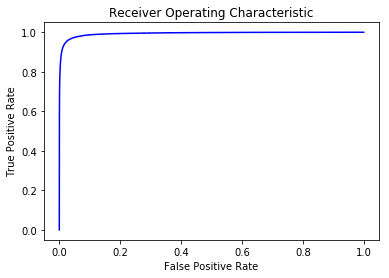

AUC: 0.993492704981733
f1_score: 0.9224298991119627
Confusion Matrix:
 [[343664   6147]
 [  3610  58013]]
#Fold: 2
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
924/924 [==============================] - 258s 279ms/step - loss: 0.2311 - accuracy: 0.9104 - val_loss: 0.0964 - val_accuracy: 0.9666
Epoch 2/7
924/924 [==============================] - 257s 279ms/step - loss: 0.1420 - accuracy: 0.9525 - val_loss: 0.0815 - val_accuracy: 0.9722
Epoch 3/7
924/924 [==============================] - 256s 277ms/step - loss: 0.1205 - accuracy: 0.9606 - val_loss: 0.0905 - val_accuracy: 0.9723
Epoch 4/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1091 - accuracy: 0.9648 - val_loss: 0.0699 - val_accuracy: 0.9768
Epoch 5/7
924/924 [==============================] - 256s 277ms/step - loss: 0.1015 - accuracy: 0.9674 - val_loss: 0.0688 - val_accuracy: 0.9774
Epoch 6/7
924/924 [==============================] - 255s 276ms/step - loss: 0.0955 - accuracy: 0.9694 - val_lo

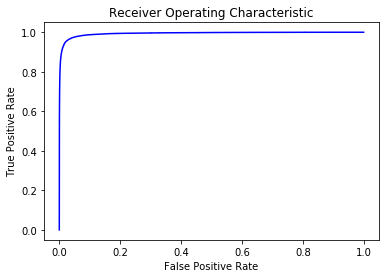

AUC: 0.9937177000768366
f1_score: 0.9244054630543441
Confusion Matrix:
 [[343863   5948]
 [  3550  58073]]
#Fold: 3
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
924/924 [==============================] - 256s 277ms/step - loss: 0.2494 - accuracy: 0.9046 - val_loss: 0.1148 - val_accuracy: 0.9588
Epoch 2/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1542 - accuracy: 0.9486 - val_loss: 0.0923 - val_accuracy: 0.9683
Epoch 3/7
924/924 [==============================] - 256s 277ms/step - loss: 0.1295 - accuracy: 0.9581 - val_loss: 0.0822 - val_accuracy: 0.9723
Epoch 4/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1161 - accuracy: 0.9627 - val_loss: 0.0807 - val_accuracy: 0.9719
Epoch 5/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1061 - accuracy: 0.9659 - val_loss: 0.0765 - val_accuracy: 0.9748
Epoch 6/7
924/924 [==============================] - 255s 276ms/step - loss: 0.0997 - accuracy: 0.9682 - val_l

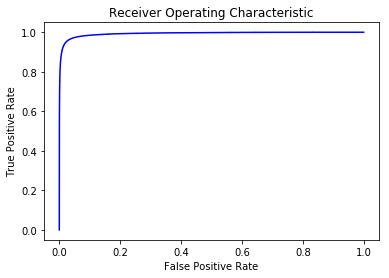

AUC: 0.9930683829996045
f1_score: 0.9238274700180452
Confusion Matrix:
 [[344042   5769]
 [  3771  57851]]
#Fold: 4
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
924/924 [==============================] - 255s 276ms/step - loss: 0.2313 - accuracy: 0.9122 - val_loss: 0.1035 - val_accuracy: 0.9646
Epoch 2/7
924/924 [==============================] - 254s 275ms/step - loss: 0.1412 - accuracy: 0.9538 - val_loss: 0.0867 - val_accuracy: 0.9708
Epoch 3/7
924/924 [==============================] - 254s 275ms/step - loss: 0.1196 - accuracy: 0.9617 - val_loss: 0.0811 - val_accuracy: 0.9722
Epoch 4/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1079 - accuracy: 0.9655 - val_loss: 0.0725 - val_accuracy: 0.9758
Epoch 5/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1008 - accuracy: 0.9680 - val_loss: 0.0716 - val_accuracy: 0.9758
Epoch 6/7
924/924 [==============================] - 255s 276ms/step - loss: 0.0946 - accuracy: 0.9700 - val_l

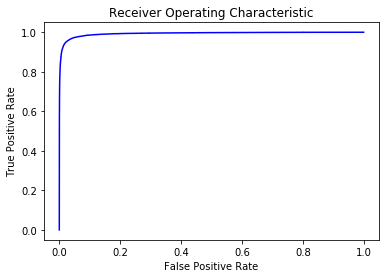

AUC: 0.99306206117913
f1_score: 0.9216993018630193
Confusion Matrix:
 [[343396   6415]
 [  3466  58156]]
#Fold: 5
Oversampling ...
Pad Sequencing ...
Modeling ...
Epoch 1/7
924/924 [==============================] - 256s 277ms/step - loss: 0.2271 - accuracy: 0.9120 - val_loss: 0.1000 - val_accuracy: 0.9654
Epoch 2/7
924/924 [==============================] - 255s 276ms/step - loss: 0.1401 - accuracy: 0.9517 - val_loss: 0.0805 - val_accuracy: 0.9728
Epoch 3/7
924/924 [==============================] - 254s 275ms/step - loss: 0.1193 - accuracy: 0.9594 - val_loss: 0.0780 - val_accuracy: 0.9734
Epoch 4/7
924/924 [==============================] - 254s 275ms/step - loss: 0.1080 - accuracy: 0.9635 - val_loss: 0.0713 - val_accuracy: 0.9751
Epoch 5/7
924/924 [==============================] - 254s 275ms/step - loss: 0.1006 - accuracy: 0.9661 - val_loss: 0.0721 - val_accuracy: 0.9757
Epoch 6/7
924/924 [==============================] - 255s 275ms/step - loss: 0.0945 - accuracy: 0.9708 - val_los

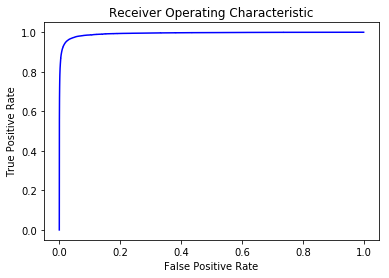

AUC: 0.9934980711623715
f1_score: 0.9232864059115812
Confusion Matrix:
 [[343824   5987]
 [  3647  57975]]


In [28]:
for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
    
    print('#Fold:', fold+1)
    
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    
    print('Oversampling ...')
    Xtrain = np.append(Xtrain, Xtrain[Ytrain==1])
    Ytrain = np.append(Ytrain, Ytrain[Ytrain==1])
    
    print('Pad Sequencing ...')
    sequence_train = tokenizer.texts_to_sequences(Xtrain)
    sequence_test = tokenizer.texts_to_sequences(Xtest)
    padata_train = pad_sequences(sequence_train,maxlen=max_seq_len, padding='post')
    padata_test = pad_sequences(sequence_test,maxlen=max_seq_len, padding='post')
    
    print('Modeling ...')
    model = create_model()
    history= model.fit(padata_train, Ytrain, validation_data=(padata_test,Ytest),epochs=epoches, batch_size=batch_size,
                       verbose=1, shuffle=True)
    
    print('Evaluating ...')
    pred_class = model.predict_classes(padata_test)
    pred_proba = model.predict(padata_test)
    Evaluation(Ytest, pred_class, pred_proba, fold)

# TFIDF Transformation with Naive Bayes modeling

#Fold: 1
Oversampling ...
Evaluating ...


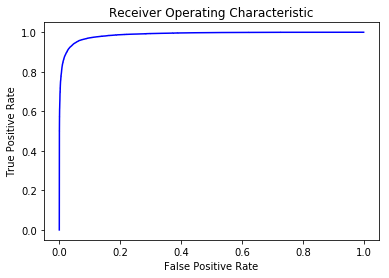

AUC: 0.9877878640555044
f1_score: 0.8856267035482331
Confusion Matrix:
 [[342544   7267]
 [  6874  54749]]
#Fold: 2
Oversampling ...
Evaluating ...


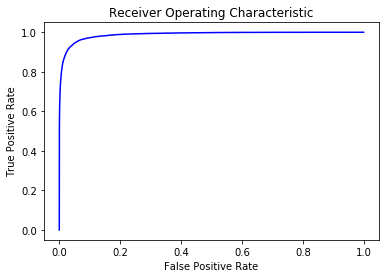

AUC: 0.9881706995361339
f1_score: 0.8856879428035328
Confusion Matrix:
 [[342545   7266]
 [  6868  54755]]
#Fold: 3
Oversampling ...
Evaluating ...


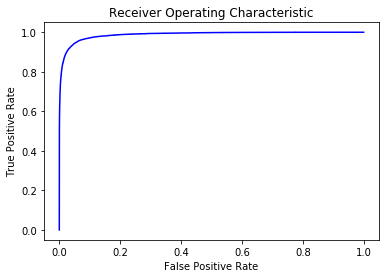

AUC: 0.9878005815532251
f1_score: 0.8860994961299872
Confusion Matrix:
 [[342570   7241]
 [  6842  54780]]
#Fold: 4
Oversampling ...
Evaluating ...


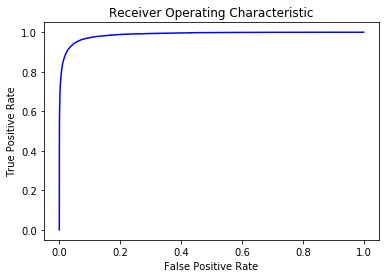

AUC: 0.9880542211173834
f1_score: 0.8863218735074838
Confusion Matrix:
 [[342645   7166]
 [  6877  54745]]
#Fold: 5
Oversampling ...
Evaluating ...


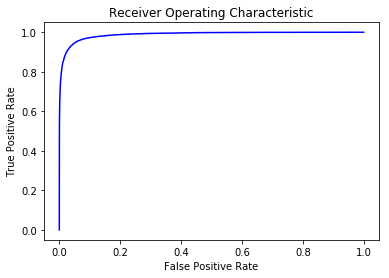

AUC: 0.9881143630168959
f1_score: 0.8863249387841148
Confusion Matrix:
 [[342756   7055]
 [  6965  54657]]


In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF = TfidfVectorizer(ngram_range=(1,3), max_features=100000)
TFIDF.fit(X)

for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
    
    print('#Fold:', fold+1)
    
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    
    print('Oversampling ...')
    Xtrain = np.append(Xtrain, Xtrain[Ytrain==1])
    Ytrain = np.append(Ytrain, Ytrain[Ytrain==1])
    
    Xtrain_tf = TFIDF.transform(Xtrain)
    Xtest_tf = TFIDF.transform(Xtest)
    
    NB = MultinomialNB()
    NB.fit(Xtrain_tf, Ytrain)    
    
    print('Evaluating ...')
    pred_class = NB.predict(Xtest_tf)
    pred_proba = NB.predict_proba(Xtest_tf)
    Evaluation(Ytest, pred_class, pred_proba[:,1], fold)

# TFIDF Transformation with Logistic Regression modeling

#Fold: 1
Oversampling ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluating ...


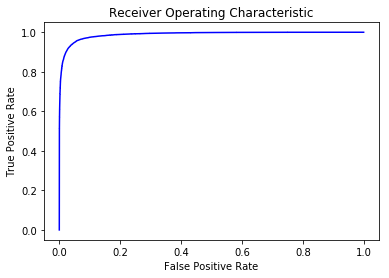

AUC: 0.9888129659122776
f1_score: 0.8894540522210919
Confusion Matrix:
 [[342659   7152]
 [  6540  55083]]
#Fold: 2
Oversampling ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluating ...


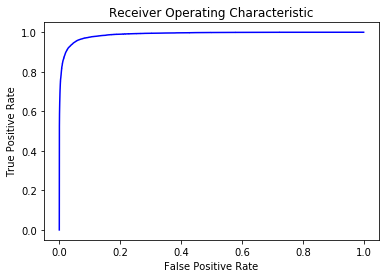

AUC: 0.989147184330603
f1_score: 0.8901987065102422
Confusion Matrix:
 [[342709   7102]
 [  6497  55126]]
#Fold: 3
Oversampling ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluating ...


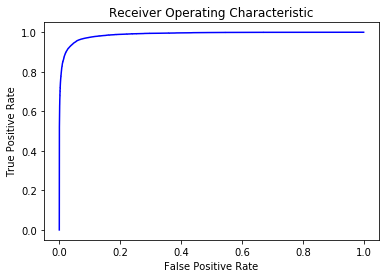

AUC: 0.9888128067297264
f1_score: 0.8898218870605712
Confusion Matrix:
 [[342683   7128]
 [  6518  55104]]
#Fold: 4
Oversampling ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluating ...


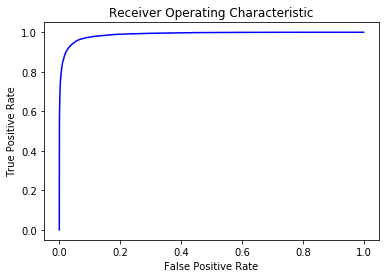

AUC: 0.9890410706841297
f1_score: 0.8895528655528009
Confusion Matrix:
 [[342678   7133]
 [  6544  55078]]
#Fold: 5
Oversampling ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluating ...


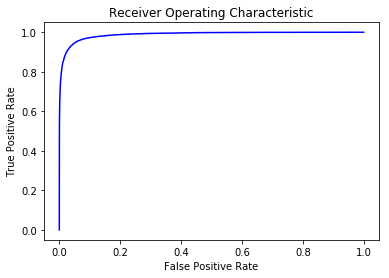

AUC: 0.9881143630168959
f1_score: 0.8863249387841148
Confusion Matrix:
 [[342756   7055]
 [  6965  54657]]


In [31]:
for fold, (train_index, test_index) in enumerate(skf.split(X,Y)):
    
    print('#Fold:', fold+1)
    
    Xtrain, Xtest = X[train_index], X[test_index]
    Ytrain, Ytest = Y[train_index], Y[test_index]
    
    print('Oversampling ...')
    Xtrain = np.append(Xtrain, Xtrain[Ytrain==1])
    Ytrain = np.append(Ytrain, Ytrain[Ytrain==1])
    
    Xtrain_tf = TFIDF.transform(Xtrain)
    Xtest_tf = TFIDF.transform(Xtest)
    
    LR = LogisticRegression()
    LR.fit(Xtrain_tf, Ytrain)    
    
    print('Evaluating ...')
    pred_class = NB.predict(Xtest_tf)
    pred_proba = NB.predict_proba(Xtest_tf)
    Evaluation(Ytest, pred_class, pred_proba[:,1], fold)